In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import pickle

In [11]:
# Transformations applied on each image => converting them to tensor and normalizing
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))])

def load_dataset(train=True):
    filename = './data/mnist_train.pkl' if train else './data/mnist_test.pkl'

    # Check if the dataset is already saved in pickle file
    if os.path.exists(filename):
        print(f"Loading from {filename}")
        with open(filename, 'rb') as f:
            dataset = pickle.load(f)
    else:
        print(f"Downloading and saving to {filename}")
        dataset = datasets.MNIST(root='./data', train=train, transform=transform, download=True)
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        with open(filename, 'wb') as f:
            pickle.dump(dataset, f)

    return dataset

# Loading datasets
train_dataset = load_dataset(train=True)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = load_dataset(train=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Loading from ./data/mnist_train.pkl
Loading from ./data/mnist_test.pkl


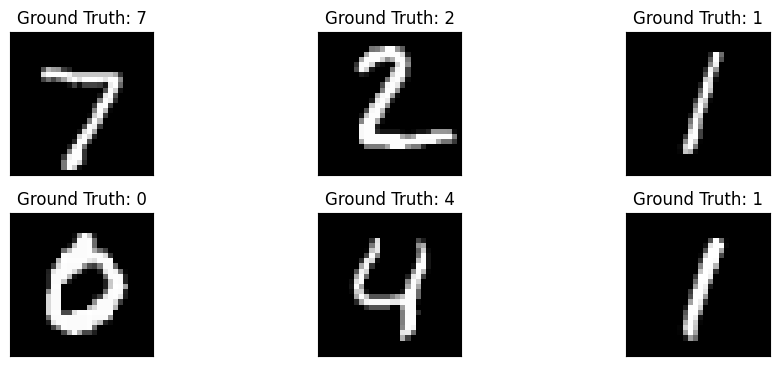

In [12]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure(figsize=(10, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title(f"Ground Truth: {example_targets[i]}")
    plt.xticks([])
    plt.yticks([])
plt.show()

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 200) ## Input Image: 28*28; Neuronen: 200
        self.fc2 = nn.Linear(200, 10) ## Neuronen: 200; Output Klassen: 10

    def forward(self, x):
        x = x.view(-1, 28*28) ## Mache aus 28*28 Bild einen 1-dim Vektor
        x = torch.relu(self.fc1(x)) ## Stecke 1-dim Vektor in Neuronenlayer
        x = self.fc2(x) ## Stecke Output von ersten Neuronenlayer in zweiten Neuronenlayer
        return x

model = Net()
kostenfunktion = nn.CrossEntropyLoss() ## Kostenfunktion (Y-Ŷ)
verarbeitungsschritt = optim.Adam(model.parameters(), lr=0.001) ## Bieger der Funktion für bessere Resultate bei Kostenfunktion

In [14]:
def train(epoch):
    model.train()
    trainings_kosten = 0
    correct = 0
    for bild, wahrheitswert in train_loader: # Wir gehen über alle Daten Bild für Bild
        verarbeitungsschritt.zero_grad()
        output = model(bild) ## Gebe Bild hinein
        loss = kostenfunktion(output, wahrheitswert) ## Ŷ - Y

        trainings_kosten += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(wahrheitswert.view_as(pred)).sum().item()

        loss.backward()
        verarbeitungsschritt.step() ## Update die Parameter des Models
    trainings_kosten /= len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    print(f'Train Epoch: {epoch} \tLoss: {trainings_kosten:.6f} \tAccuracy: {train_accuracy:.2f}%')
    return trainings_kosten, train_accuracy

def test():
    model.eval()
    test_kosten = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_kosten += kostenfunktion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_kosten /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_kosten:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({test_accuracy:.0f}%)\n')
    return test_kosten, test_accuracy

In [15]:
epochs = 10
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train(epoch)
    test_loss, test_accuracy = test()
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Train Epoch: 1 	Loss: 0.012453 	Accuracy: 93.97%

Test set: Average loss: 0.0063, Accuracy: 9692/10000 (97%)
Train Epoch: 2 	Loss: 0.006086 	Accuracy: 97.05%

Test set: Average loss: 0.0058, Accuracy: 9723/10000 (97%)
Train Epoch: 3 	Loss: 0.004330 	Accuracy: 97.82%

Test set: Average loss: 0.0051, Accuracy: 9765/10000 (98%)
Train Epoch: 4 	Loss: 0.003545 	Accuracy: 98.23%

Test set: Average loss: 0.0057, Accuracy: 9762/10000 (98%)
Train Epoch: 5 	Loss: 0.002856 	Accuracy: 98.48%

Test set: Average loss: 0.0055, Accuracy: 9767/10000 (98%)
Train Epoch: 6 	Loss: 0.002580 	Accuracy: 98.68%

Test set: Average loss: 0.0058, Accuracy: 9783/10000 (98%)
Train Epoch: 7 	Loss: 0.002201 	Accuracy: 98.85%

Test set: Average loss: 0.0069, Accuracy: 9766/10000 (98%)
Train Epoch: 8 	Loss: 0.002155 	Accuracy: 98.89%

Test set: Average loss: 0.0076, Accuracy: 9760/10000 (98%)
Train Epoch: 9 	Loss: 0.001795 	Accuracy: 99.10%

Test set: Average loss: 0.0067, Accuracy: 9793/10000 (98%)
Train Epoch: 10 	Lo

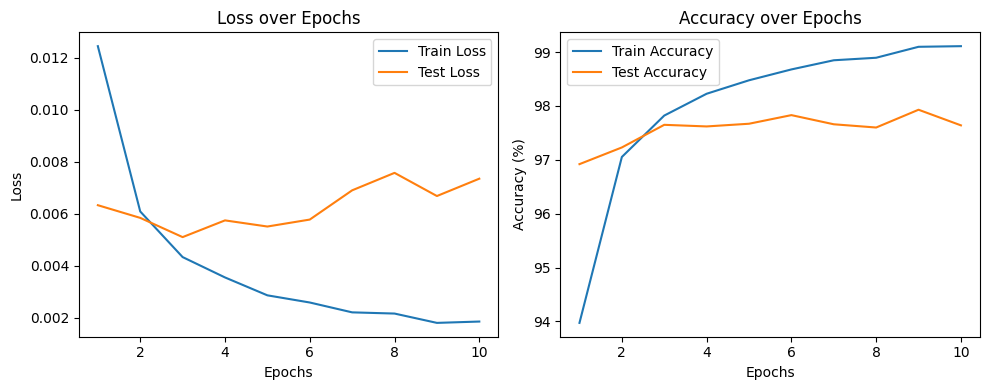

In [16]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

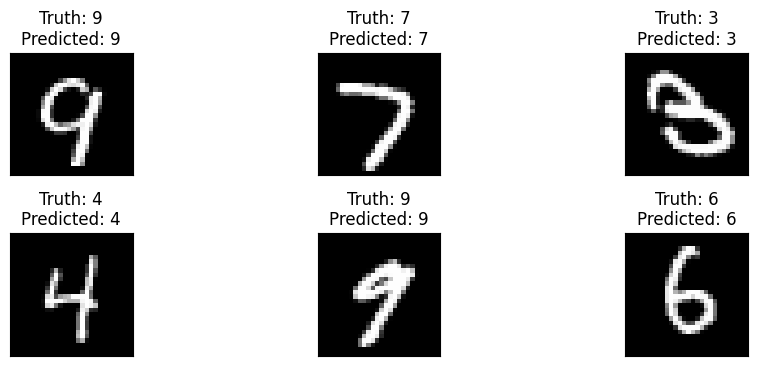

In [17]:
with torch.no_grad():
    batch_idx, (example_data, example_targets) = next(examples)
    output = model(example_data)
    predicted = output.argmax(dim=1, keepdim=True)

fig = plt.figure(figsize=(10, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title(f"Truth: {example_targets[i]}\nPredicted: {predicted[i].item()}")
    plt.xticks([])
    plt.yticks([])
plt.show()

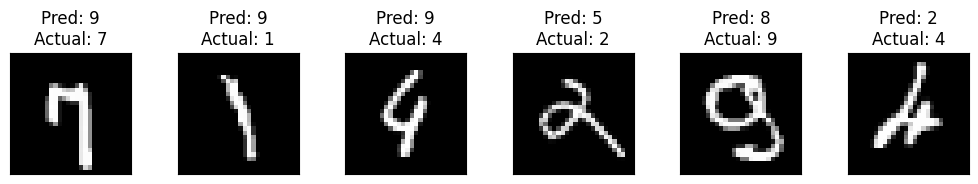

In [18]:
def plot_incorrect_predictions(model, loader, num_images=6):
    model.eval()
    incorrect_examples = []
    
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            idxs_mask = ((pred == target.view_as(pred)) == False).view(-1)
            incorrect_preds = pred[idxs_mask].view(-1)
            actual_labels = target.view_as(pred)[idxs_mask].view(-1)
            data = data[idxs_mask]
            for i in range(data.shape[0]):
                if len(incorrect_examples) < num_images:
                    incorrect_examples.append((data[i], incorrect_preds[i], actual_labels[i]))
                else:
                    break
            if len(incorrect_examples) == num_images:
                break

    fig = plt.figure(figsize=(10, 4))
    for i, (img, pred, actual) in enumerate(incorrect_examples):
        img = img.view(28, 28)
        plt.subplot(1, num_images, i + 1)
        plt.tight_layout()
        plt.imshow(img, cmap='gray', interpolation='none')
        plt.title(f"Pred: {pred.item()}\nActual: {actual.item()}")
        plt.xticks([])
        plt.yticks([])
    plt.show()

# Usage
plot_incorrect_predictions(model, test_loader)